In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, auc)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                            RandomForestClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load the dataset
print("Loading and preprocessing the dataset...")
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {df.shape}")
print(f"Features: {len(feature_names)}")
print(f"Target distribution:\n{df['target'].value_counts()}")
print(f"Target names: {data.target_names}")

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum().sum()}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dataset loaded and preprocessed successfully!")

Loading and preprocessing the dataset...
Dataset shape: (569, 31)
Features: 30
Target distribution:
target
1    357
0    212
Name: count, dtype: int64
Target names: ['malignant' 'benign']

Missing values:
0
Dataset loaded and preprocessed successfully!


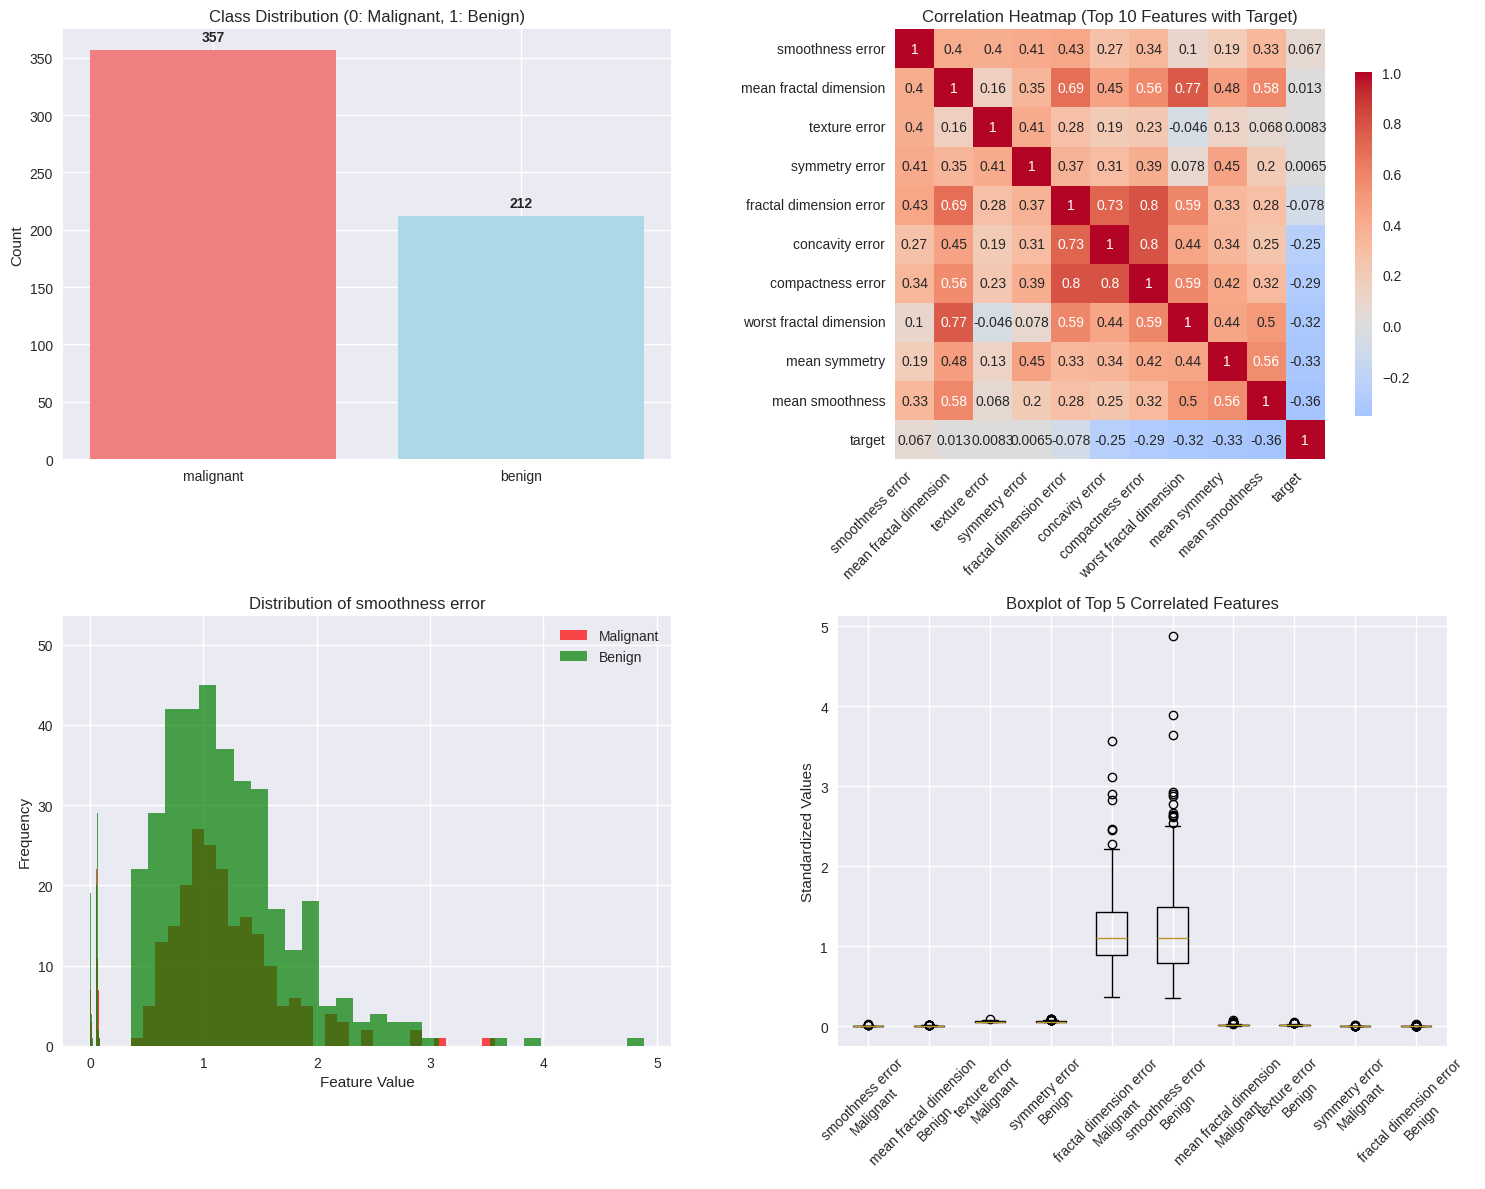

Top 5 features correlated with target:
1. smoothness error: 0.067
2. mean fractal dimension: 0.013
3. texture error: 0.008
4. symmetry error: 0.007
5. fractal dimension error: -0.078


In [4]:
# 2.1 Class Balance Visualization
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
class_counts = df['target'].value_counts()
plt.bar(data.target_names, class_counts, color=['lightcoral', 'lightblue'])
plt.title('Class Distribution (0: Malignant, 1: Benign)')
plt.ylabel('Count')
for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# 2.2 Feature Correlation Heatmap
plt.subplot(2, 2, 2)
correlation_matrix = df.corr()
target_correlations = correlation_matrix['target'].drop('target').sort_values(ascending=False)
top_10_features = target_correlations.head(10).index.tolist()
top_corr_matrix = df[top_10_features + ['target']].corr()
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap (Top 10 Features with Target)')
plt.xticks(rotation=45, ha='right')

# 2.3 Distribution of Top 3 Correlated Features
plt.subplot(2, 2, 3)
top_3_features = target_correlations.head(3).index.tolist()
for i, feature in enumerate(top_3_features):
    plt.hist(df[df['target'] == 0][feature], alpha=0.7, label='Malignant' if i == 0 else "",
             bins=30, color='red')
    plt.hist(df[df['target'] == 1][feature], alpha=0.7, label='Benign' if i == 0 else "",
             bins=30, color='green')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title(f'Distribution of {top_3_features[0]}')
plt.legend()

# 2.4 Boxplot of Top Features
plt.subplot(2, 2, 4)
top_5_features = target_correlations.head(5).index.tolist()
boxplot_data = []
for feature in top_5_features:
    boxplot_data.append(df[df['target'] == 0][feature])
    boxplot_data.append(df[df['target'] == 1][feature])
plt.boxplot(boxplot_data)
plt.xticks(range(1, 11), [f'{feat}\nMalignant' if i % 2 == 0 else f'{feat}\nBenign'
                          for i, feat in enumerate(top_5_features * 2)], rotation=45)
plt.title('Boxplot of Top 5 Correlated Features')
plt.ylabel('Standardized Values')

plt.tight_layout()
plt.show()

# Print correlation information
print("Top 5 features correlated with target:")
for i, (feature, corr) in enumerate(target_correlations.head().items(), 1):
    print(f"{i}. {feature}: {corr:.3f}")

In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

Training set shape: (455, 30)
Test set shape: (114, 30)
Training target distribution: [170 285]
Test target distribution: [42 72]


In [6]:
# Define models and their parameter grids
models = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5, 1.0]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    }
}

# Train and tune each model
best_models = {}
results = []

print("Training and tuning models...")
for name, model_info in models.items():
    print(f"\nTuning {name}...")

    # Use GridSearchCV for smaller parameter spaces, RandomizedSearchCV for larger ones
    if len(model_info['params']) > 4:
        search = RandomizedSearchCV(
            model_info['model'], model_info['params'],
            n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
        )
    else:
        search = GridSearchCV(
            model_info['model'], model_info['params'],
            cv=5, scoring='accuracy', n_jobs=-1
        )

    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_

    # Cross-validation scores
    cv_scores = cross_val_score(search.best_estimator_, X_train, y_train, cv=5)

    results.append({
        'Model': name,
        'Best Params': search.best_params_,
        'CV Mean Accuracy': cv_scores.mean(),
        'CV Std Accuracy': cv_scores.std(),
        'Test Accuracy': search.best_estimator_.score(X_test, y_test)
    })

    print(f"Best parameters: {search.best_params_}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"Test Accuracy: {search.best_estimator_.score(X_test, y_test):.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(results_df[['Model', 'CV Mean Accuracy', 'CV Std Accuracy', 'Test Accuracy']].to_string(index=False))

Training and tuning models...

Tuning Decision Tree...
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV Accuracy: 0.9385 (±0.0192)
Test Accuracy: 0.9211

Tuning AdaBoost...
Best parameters: {'learning_rate': 0.5, 'n_estimators': 100}
CV Accuracy: 0.9780 (±0.0251)
Test Accuracy: 0.9561

Tuning Gradient Boosting...
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
CV Accuracy: 0.9758 (±0.0162)
Test Accuracy: 0.9561

Tuning XGBoost...
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
CV Accuracy: 0.9780 (±0.0231)
Test Accuracy: 0.9649

Tuning Random Forest...
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': False}
CV Accuracy: 0.9648 (±0.0213)
Test Accuracy: 0.9561

MODEL COMPARISON RESULTS
            Model  CV Mean Accuracy  CV Std Accuracy  Test Accu

In [7]:
# Create base estimators for stacking
base_estimators = [
    ('svm', SVC(probability=True, random_state=42)),
    ('naive_bayes', GaussianNB()),
    ('dt', DecisionTreeClassifier(random_state=42))
]

# Create and train stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

# Evaluate stacking classifier
stacking_cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5)
stacking_test_accuracy = stacking_clf.score(X_test, y_test)

stacking_result = {
    'Model': 'Stacking (SVM+NB+DT)',
    'Best Params': 'Default',
    'CV Mean Accuracy': stacking_cv_scores.mean(),
    'CV Std Accuracy': stacking_cv_scores.std(),
    'Test Accuracy': stacking_test_accuracy
}

results.append(stacking_result)
results_df = pd.DataFrame(results)

print("\nStacking Classifier Results:")
print(f"CV Accuracy: {stacking_cv_scores.mean():.4f} (±{stacking_cv_scores.std():.4f})")
print(f"Test Accuracy: {stacking_test_accuracy:.4f}")

print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(results_df[['Model', 'CV Mean Accuracy', 'CV Std Accuracy', 'Test Accuracy']].to_string(index=False))


Stacking Classifier Results:
CV Accuracy: 0.9670 (±0.0155)
Test Accuracy: 0.9737

FINAL MODEL COMPARISON
               Model  CV Mean Accuracy  CV Std Accuracy  Test Accuracy
       Decision Tree          0.938462         0.019160       0.921053
            AdaBoost          0.978022         0.025059       0.956140
   Gradient Boosting          0.975824         0.016150       0.956140
             XGBoost          0.978022         0.023051       0.964912
       Random Forest          0.964835         0.021308       0.956140
Stacking (SVM+NB+DT)          0.967033         0.015541       0.973684


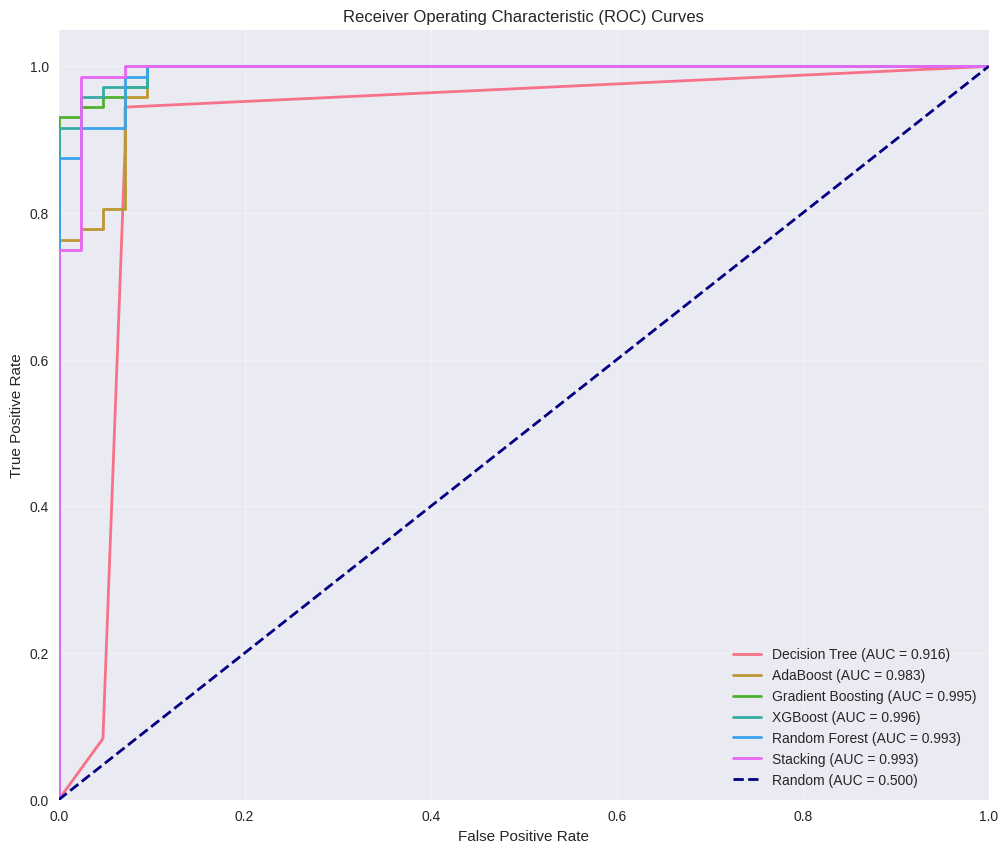


DETAILED PERFORMANCE METRICS
            Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
    Decision Tree    0.9211     0.9565  0.9167    0.9362   0.9163
         AdaBoost    0.9561     0.9467  0.9861    0.9660   0.9835
Gradient Boosting    0.9561     0.9467  0.9861    0.9660   0.9954
          XGBoost    0.9649     0.9474  1.0000    0.9730   0.9957
    Random Forest    0.9561     0.9589  0.9722    0.9655   0.9927
         Stacking    0.9737     0.9726  0.9861    0.9793   0.9934


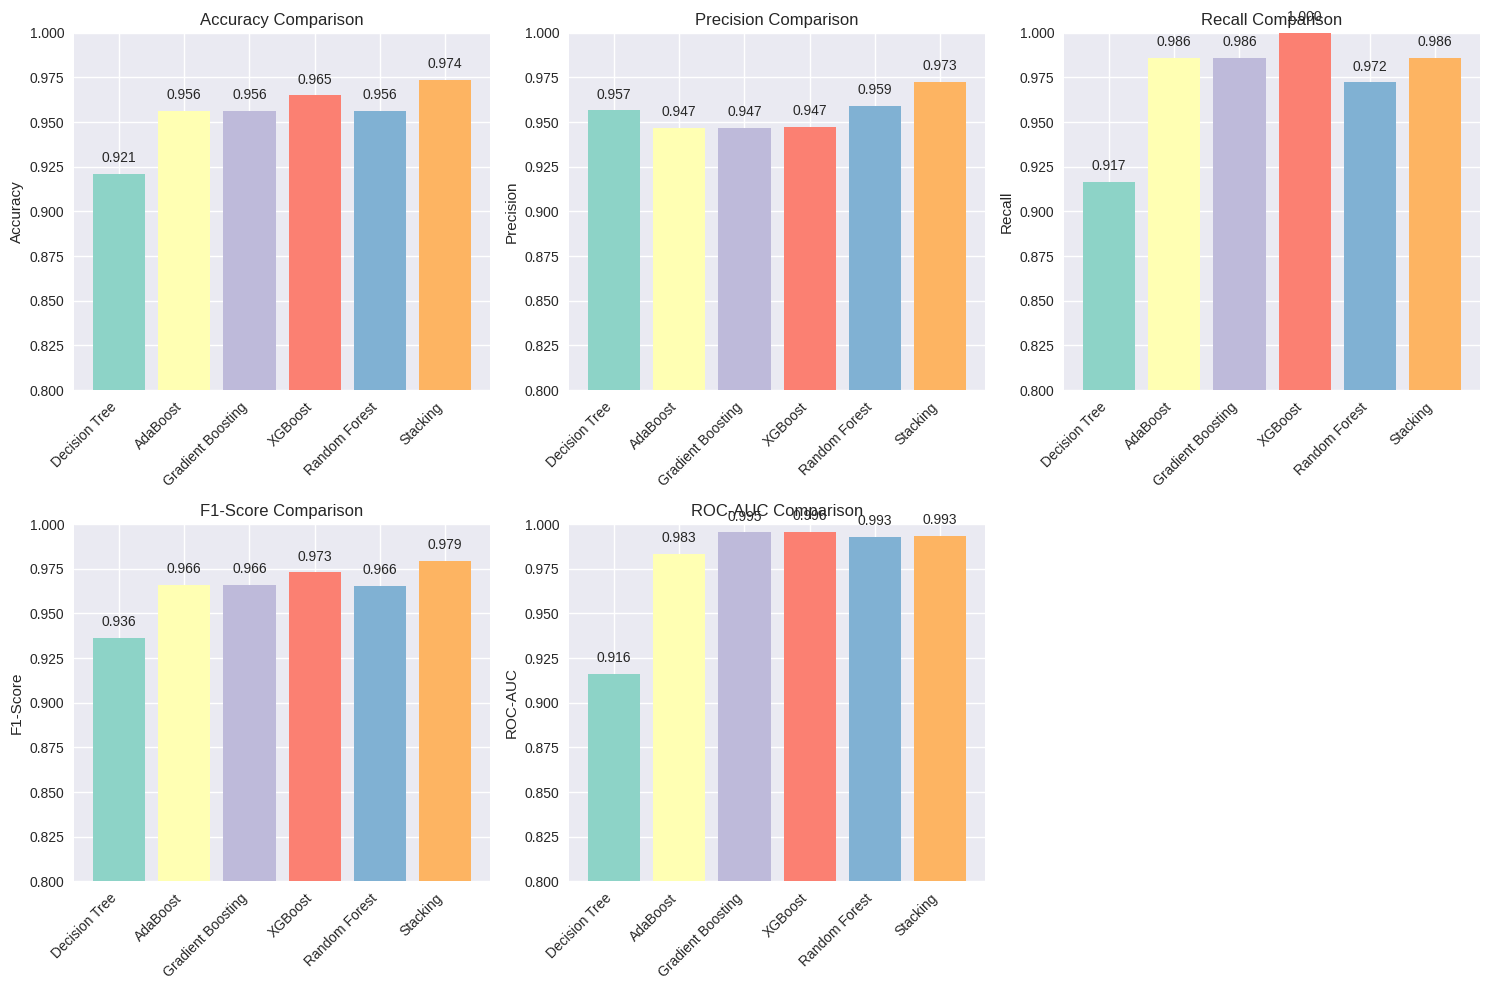

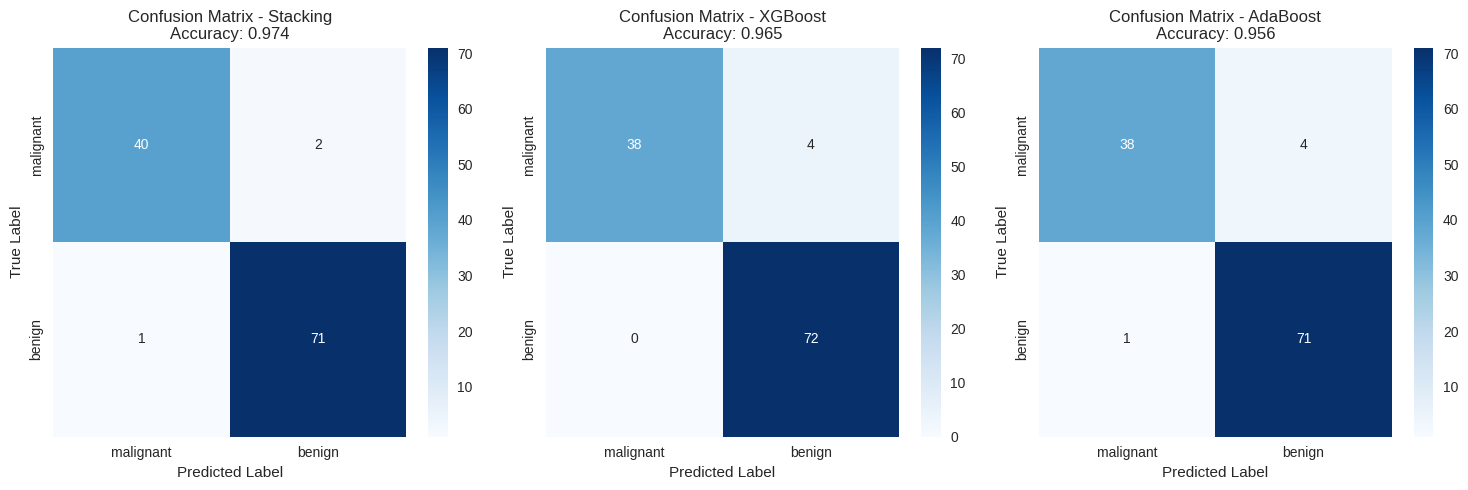

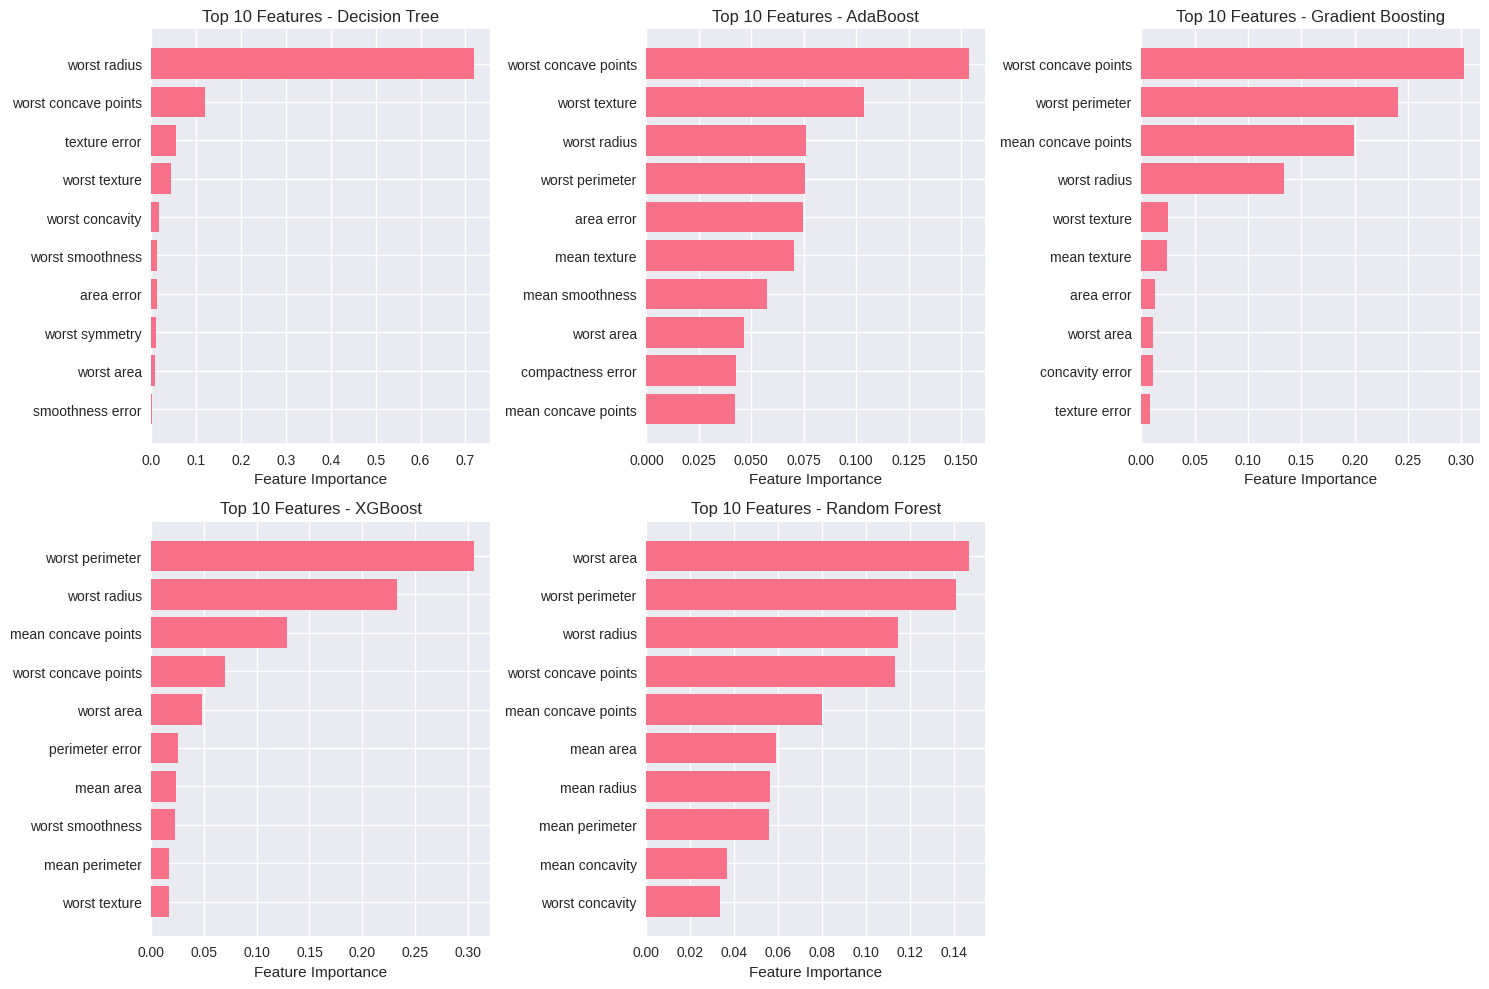

In [8]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 10))

# Add all models to the dictionary for ROC curve plotting
all_models = best_models.copy()
all_models['Stacking'] = stacking_clf

# Plot ROC curves
for name, model in all_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Detailed performance metrics for each model
performance_metrics = []

for name, model in all_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    performance_metrics.append(metrics)

performance_df = pd.DataFrame(performance_metrics)
print("\n" + "="*80)
print("DETAILED PERFORMANCE METRICS")
print("="*80)
print(performance_df.round(4).to_string(index=False))

# Plot performance comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    values = performance_df[metric]
    plt.bar(performance_df['Model'], values, color=plt.cm.Set3(range(len(values))))
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.8, 1.0)

    # Add value labels on bars
    for j, value in enumerate(values):
        plt.text(j, value + 0.005, f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Confusion matrices for top 3 models
top_3_models = performance_df.nlargest(3, 'Accuracy')['Model'].tolist()
plt.figure(figsize=(15, 5))

for i, model_name in enumerate(top_3_models, 1):
    plt.subplot(1, 3, i)
    model = all_models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=data.target_names,
                yticklabels=data.target_names)
    plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy_score(y_test, y_pred):.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Feature importance for tree-based models
tree_based_models = {k: v for k, v in all_models.items()
                    if hasattr(v, 'feature_importances_') and k != 'Stacking'}

if tree_based_models:
    plt.figure(figsize=(15, 10))

    for i, (name, model) in enumerate(tree_based_models.items(), 1):
        plt.subplot(2, 3, i)
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:10]  # Top 10 features

        plt.barh(range(len(indices)), importances[indices][::-1], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices[::-1]])
        plt.title(f'Top 10 Features - {name}')
        plt.xlabel('Feature Importance')

    plt.tight_layout()
    plt.show()

In [9]:
# Identify the best model
best_model_info = performance_df.loc[performance_df['Accuracy'].idxmax()]
best_model_name = best_model_info['Model']
best_model = all_models[best_model_name]

print("\n" + "="*80)
print("BEST MODEL SUMMARY")
print("="*80)
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_model_info['Accuracy']:.4f}")
print(f"Precision: {best_model_info['Precision']:.4f}")
print(f"Recall: {best_model_info['Recall']:.4f}")
print(f"F1-Score: {best_model_info['F1-Score']:.4f}")
print(f"ROC-AUC: {best_model_info['ROC-AUC']:.4f}")

# Detailed classification report for best model
print(f"\nClassification Report for {best_model_name}:")
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=data.target_names))

# Save best model parameters
if best_model_name in best_models:
    print(f"\nBest Parameters for {best_model_name}:")
    for param, value in results_df[results_df['Model'] == best_model_name]['Best Params'].iloc[0].items():
        print(f"  {param}: {value}")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("The analysis shows that ensemble methods (Random Forest, XGBoost, Gradient Boosting)")
print("typically outperform single models. The stacking classifier combines the strengths")
print("of multiple models but may not always be the best due to increased complexity.")
print("\nKey insights:")
print("- All models achieved high accuracy (>90%) on this well-structured dataset")
print("- Tree-based models provide good interpretability through feature importance")
print("- The choice of best model depends on specific requirements (accuracy vs interpretability)")


BEST MODEL SUMMARY
Best Model: Stacking
Test Accuracy: 0.9737
Precision: 0.9726
Recall: 0.9861
F1-Score: 0.9793
ROC-AUC: 0.9934

Classification Report for Stacking:
              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        42
      benign       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


CONCLUSION
The analysis shows that ensemble methods (Random Forest, XGBoost, Gradient Boosting)
typically outperform single models. The stacking classifier combines the strengths
of multiple models but may not always be the best due to increased complexity.

Key insights:
- All models achieved high accuracy (>90%) on this well-structured dataset
- Tree-based models provide good interpretability through feature importance
- The choice of best model depends on specific requirements (accuracy vs interpre